# Imports

In [1]:
!pip install -q pymc

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import os

# Basic Workflow

## Data Preparation

In [3]:
# Simulate some data for linear regression y = a + b*x + ε
np.random.seed(42)
n = 100  # Number of data points
X = np.linspace(0, 10, n)  # Independent variable
true_intercept = 1.5
true_slope = 2.5
true_sigma = 1.0
Y = true_intercept + true_slope * X + np.random.normal(0, true_sigma, size=n)

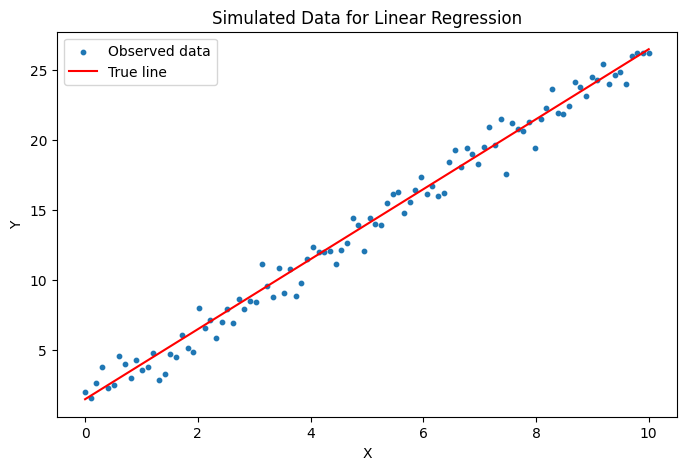

In [4]:
# Visualize the simulated data
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, s=10, label="Observed data")
plt.plot(X, true_intercept + true_slope * X, label="True line", color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Simulated Data for Linear Regression')
plt.show()

## Define the Model

In [5]:
# Define the PyMC model
with pm.Model() as linear_model:
    # Priors for unknown model parameters
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of the outcome
    mu = intercept + slope * X

    # Likelihood (sampling distribution) of the observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

## Perform Inference

In [6]:
# Perform inference
with linear_model:
    # Perform MCMC sampling
    trace = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.95)

## Posterior Analysis

           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  1.33  0.18    0.99     1.66        0.0      0.0   2820.82   
sigma      0.92  0.07    0.80     1.04        0.0      0.0   4222.48   
slope      2.51  0.03    2.46     2.57        0.0      0.0   2819.62   

           ess_tail  r_hat  
intercept   3023.36    1.0  
sigma       3791.55    1.0  
slope       3244.18    1.0  


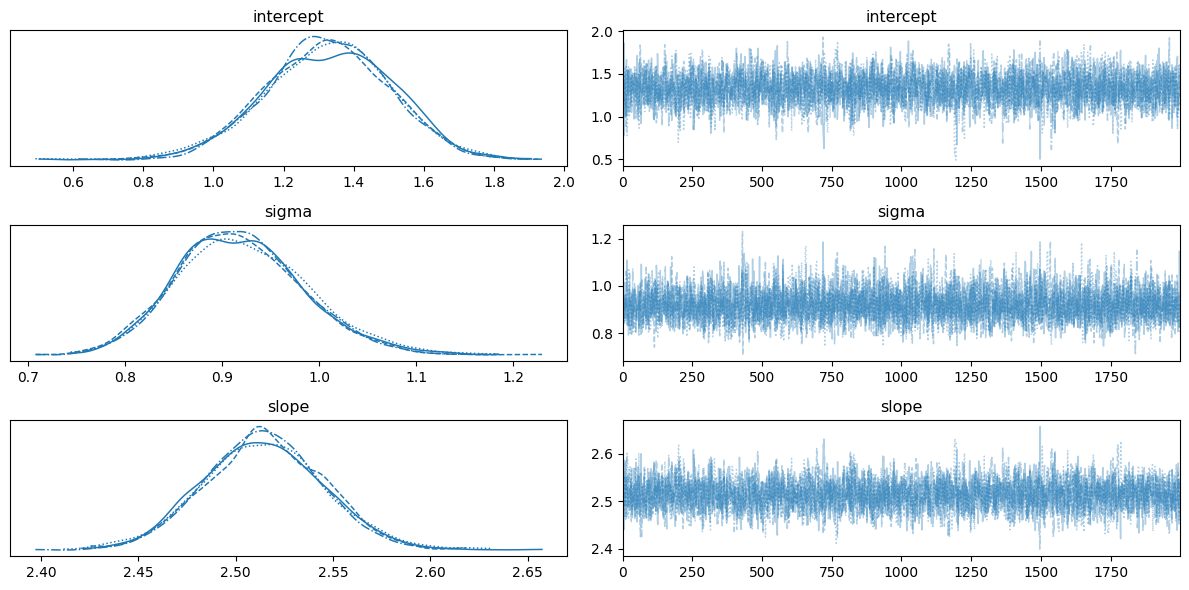

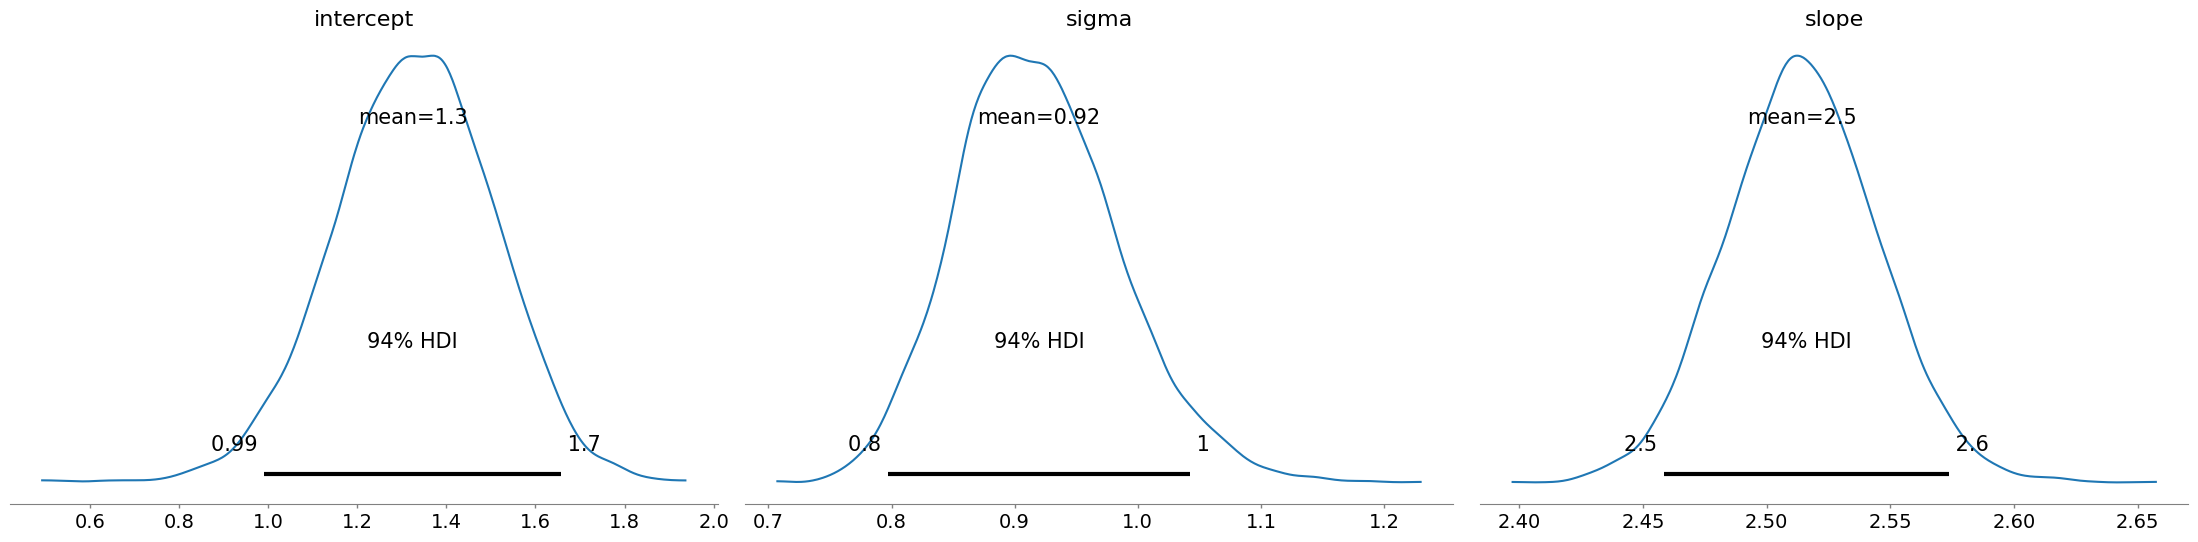

In [7]:
# Summary of the trace
print(az.summary(trace, round_to=2))

# Plotting the trace
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plotting posterior distributions
az.plot_posterior(trace)
plt.tight_layout()
plt.show()

## Model Diagnostics

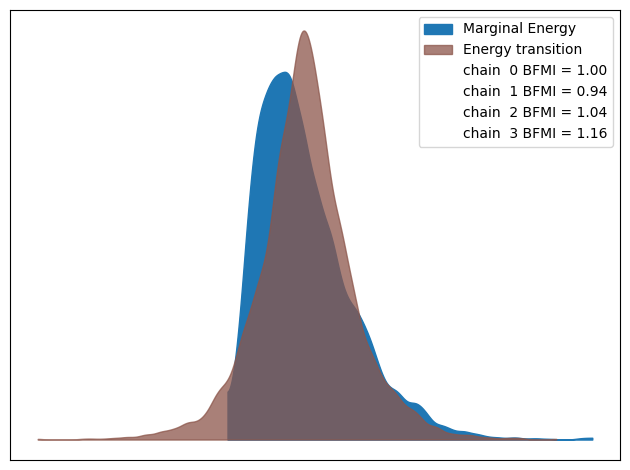

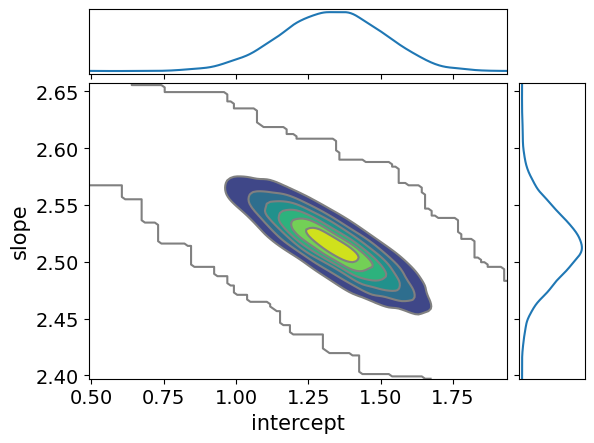

In [8]:
# Plot the energy plot
az.plot_energy(trace)
plt.tight_layout()
plt.show()

# Plot the pair plot
az.plot_pair(trace, var_names=["intercept", "slope"], kind="kde", marginals=True)
plt.show()

## Posterior Predictive Checks

In [9]:
# Perform posterior predictive checks
with linear_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Extract the posterior predictive samples for Y_obs
posterior_predictive_samples = posterior_predictive.posterior_predictive["Y_obs"].values

# Take the mean over the chains to reduce dimensions, resulting in (2000, 100)
posterior_predictive_mean = posterior_predictive_samples.mean(axis=0)

In [10]:
# Print the type of the InferenceData object
print(f"Type of posterior_predictive: {type(posterior_predictive)}")

# Print the groups available in the InferenceData object
print(f"\nGroups available in posterior_predictive: {posterior_predictive.groups()}")

# Check if 'posterior_predictive' group is present and print its contents
if 'posterior_predictive' in posterior_predictive.groups():
    print("\nContents of the 'posterior_predictive' group:")
    print(posterior_predictive.posterior_predictive)

    # Print the available variables in the posterior_predictive group
    print(f"\nVariables in 'posterior_predictive': {posterior_predictive.posterior_predictive.data_vars}")

    # Print the shape of each variable
    for var in posterior_predictive.posterior_predictive.data_vars:
        print(f"\nShape of '{var}': {posterior_predictive.posterior_predictive[var].shape}")
else:
    print("\nNo 'posterior_predictive' group found in the InferenceData object.")

Type of posterior_predictive: <class 'arviz.data.inference_data.InferenceData'>

Groups available in posterior_predictive: ['posterior_predictive', 'observed_data']

Contents of the 'posterior_predictive' group:
<xarray.Dataset> Size: 6MB
Dimensions:      (chain: 4, draw: 2000, Y_obs_dim_2: 100)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 16kB 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 6MB 1.199 1.623 ... 25.98
Attributes:
    created_at:                 2024-08-29T18:28:24.528238+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.4

Variables in 'posterior_predictive': Data variables:
    Y_obs    (chain, draw, Y_obs_dim_2) float64 6MB 1.199 1.623 ... 25.47 25.98

Shape of 'Y_obs': (4, 2000, 100)


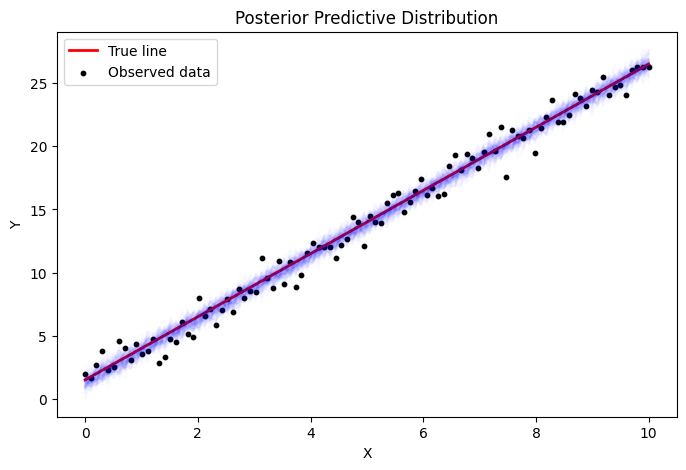

In [11]:
# Visualize posterior predictive distribution
plt.figure(figsize=(8, 5))

# Plot the true line
plt.plot(X, true_intercept + true_slope * X, label="True line", color='red', linewidth=2)

# Plot posterior predictive samples
for i in range(100):
    plt.plot(X, posterior_predictive_mean[i], color='blue', alpha=0.02)

# Plot the observed data
plt.scatter(X, Y, s=10, label="Observed data", color='black')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Posterior Predictive Distribution')
plt.show()

## Model Comparison

In [12]:
# Define the original model
with pm.Model() as linear_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + slope * X
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Sample from the posterior, ensuring the log-likelihood is included
    trace = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.95, idata_kwargs={"log_likelihood": True})

# Define an alternative model
with pm.Model() as linear_model_alt:
    intercept_alt = pm.Normal("intercept", mu=1, sigma=5)
    slope_alt = pm.Normal("slope", mu=3, sigma=5)
    sigma_alt = pm.HalfNormal("sigma", sigma=1)

    mu_alt = intercept_alt + slope_alt * X
    Y_obs_alt = pm.Normal("Y_obs", mu=mu_alt, sigma=sigma_alt, observed=Y)

    # Sample from the posterior, ensuring the log-likelihood is included
    trace_alt = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.95, idata_kwargs={"log_likelihood": True})

# Model comparison using LOO
loo_comparison = az.compare({"Model 1": trace, "Model 2": trace_alt}, ic="loo")
print("\n")
display(loo_comparison)

rank    elpd_loo     p_loo  elpd_diff  weight        se       dse  \
Model 2     0 -134.698318  2.876067   0.000000     1.0  6.963407  0.000000   
Model 1     1 -134.701580  2.883236   0.003263     0.0  6.973760  0.044934   

         warning scale  
Model 2    False   log  
Model 1    False   log

## Save & Load Model

File linear_model_trace.nc already exists. Skipping save step.


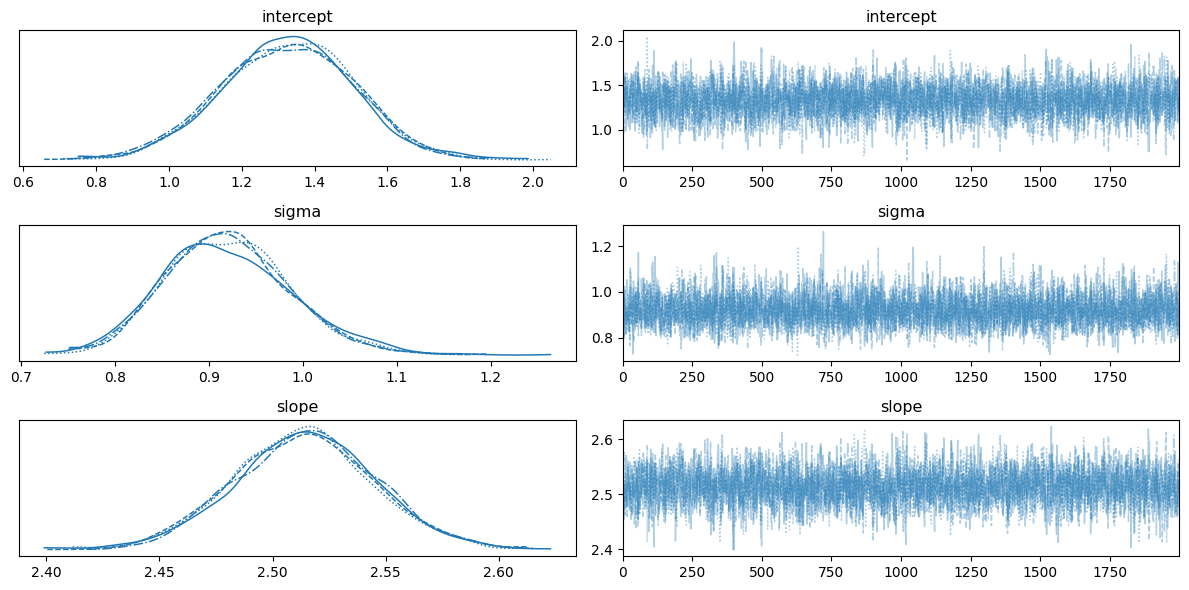

In [13]:
# Define the file path
file_path = "linear_model_trace.nc"

# Check if the file already exists
if not os.path.exists(file_path):
    # Save the model and trace
    az.to_netcdf(trace, file_path)
    print(f"Trace saved to {file_path}")
else:
    print(f"File {file_path} already exists. Skipping save step.")

# Load the model and trace later
loaded_trace = az.from_netcdf(file_path)

# Verify that the trace is loaded correctly
az.plot_trace(loaded_trace)
plt.tight_layout()
plt.show()

# Hierarchical Workflow

## Data Preparation

In [14]:
# Simulate hierarchical data with missing values for linear regression
np.random.seed(42)
n_groups = 4
n = 50
X = np.linspace(0, 10, n)
group_idx = np.repeat(np.arange(n_groups), n)
true_intercepts = np.array([1.5, 2.0, 2.5, 3.0])
true_slopes = np.array([2.5, 3.0, 3.5, 4.0])
true_sigma = 1.0
Y = np.hstack([true_intercepts[i] + true_slopes[i] * X + np.random.normal(0, true_sigma, size=n) for i in range(n_groups)])

In [15]:
# Introduce missing data
Y_missing = Y.copy()
missing_mask = np.random.rand(Y_missing.size) < 0.1
Y_missing[missing_mask] = np.nan

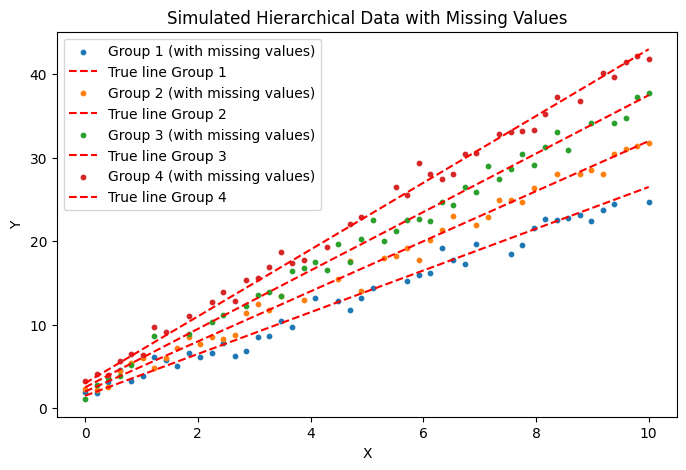

In [16]:
# Visualize the simulated data with missing values
plt.figure(figsize=(8, 5))
for i in range(n_groups):
    plt.scatter(X, Y_missing[i*n:(i+1)*n], s=10, label=f"Group {i+1} (with missing values)")
    plt.plot(X, true_intercepts[i] + true_slopes[i] * X, label=f"True line Group {i+1}", color='red', linestyle='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Simulated Hierarchical Data with Missing Values')
plt.show()

## Define the Model

In [17]:
import warnings
from pymc.exceptions import ImputationWarning

# Suppress the specific imputation warning
warnings.filterwarnings('ignore', category=ImputationWarning)

# Suppress the specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning, message="Your data appears to have a single value or no finite values")
warnings.filterwarnings("ignore", category=UserWarning, message="For one or more samples the posterior variance of the log predictive densities exceeds")

# Suppress all RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

X_repeated shape: (200,)



ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


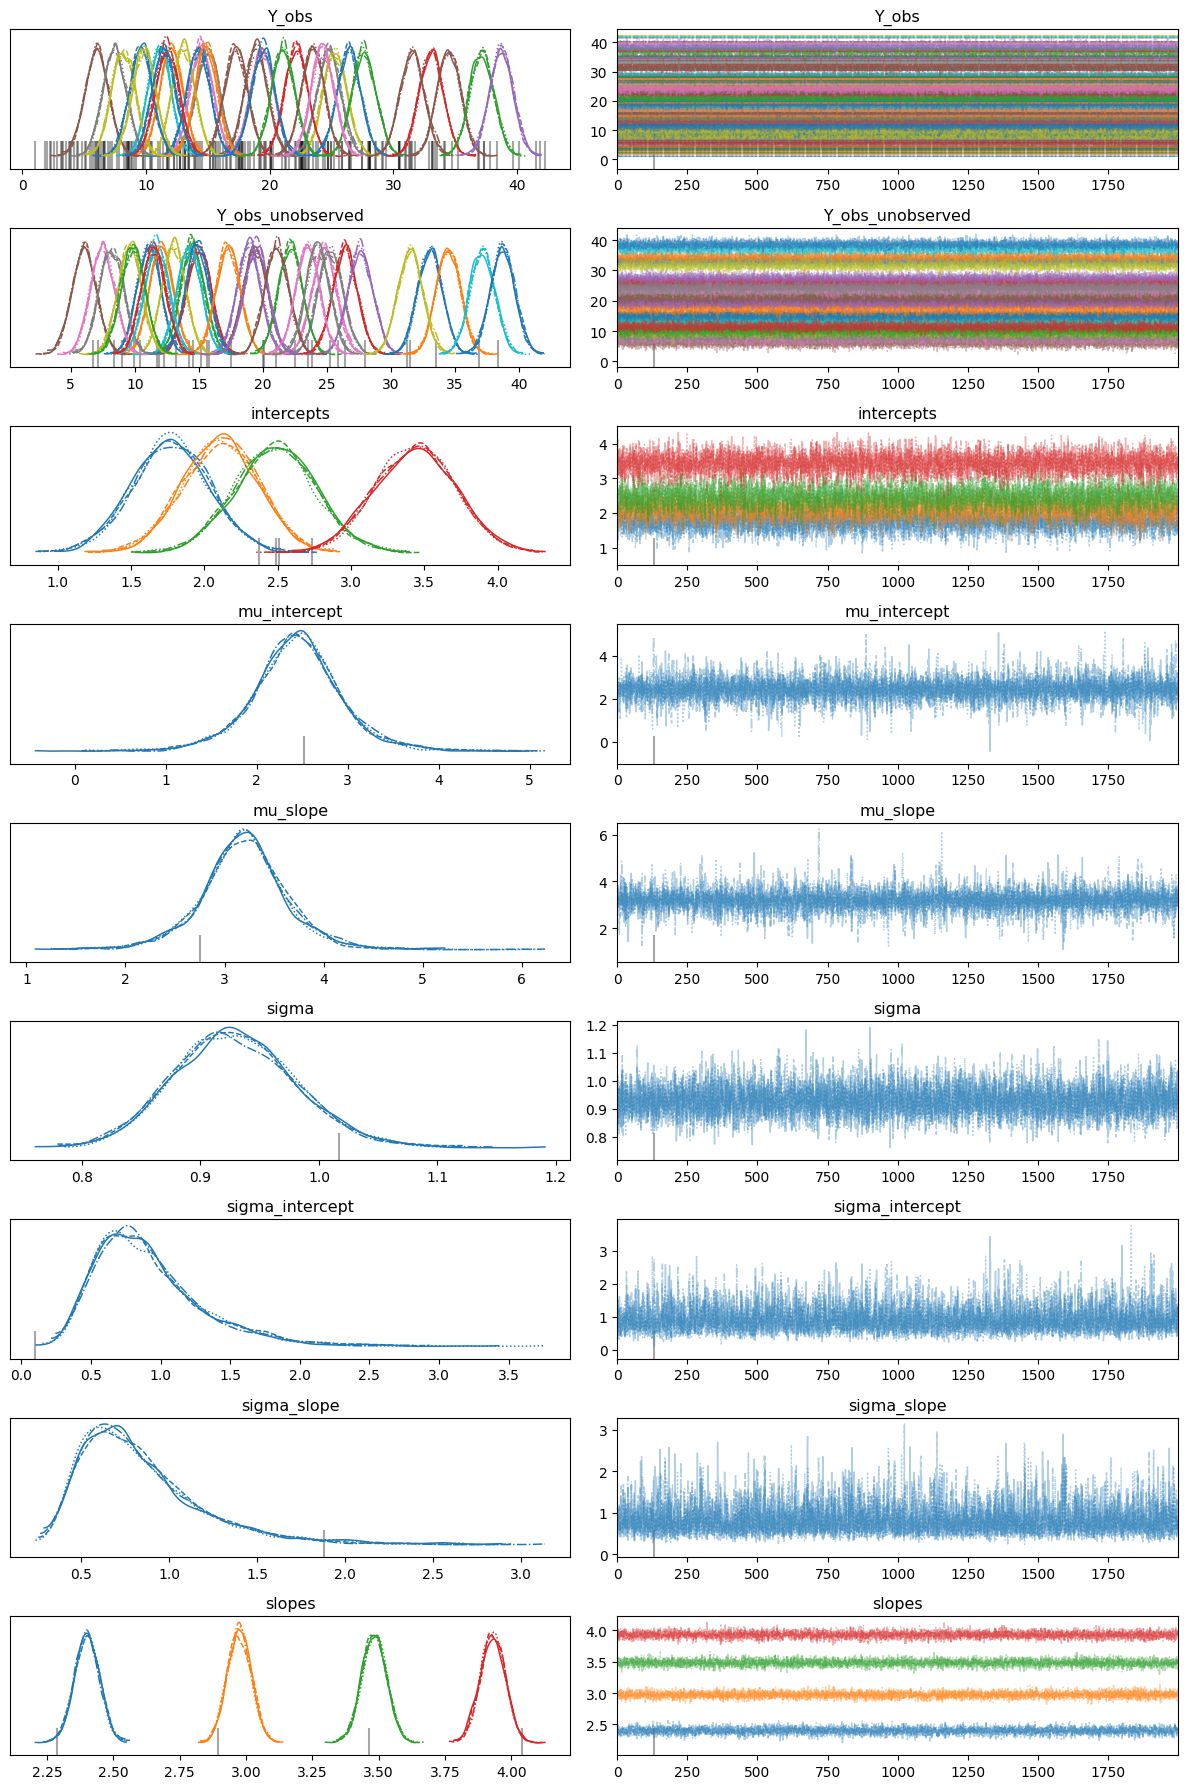

In [18]:
# Repeat X for each group to align with group_idx
X_repeated = np.tile(X, n_groups)
print(f"X_repeated shape: {X_repeated.shape}\n")

# Define the Hierarchical Model
with pm.Model() as hierarchical_model:
    # Hyperpriors for the group nodes
    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)
    sigma_intercept = pm.HalfNormal("sigma_intercept", sigma=1)

    mu_slope = pm.Normal("mu_slope", mu=0, sigma=10)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=1)

    # Group-level intercepts and slopes
    intercepts = pm.Normal("intercepts", mu=mu_intercept, sigma=sigma_intercept, shape=n_groups)
    slopes = pm.Normal("slopes", mu=mu_slope, sigma=sigma_slope, shape=n_groups)

    # Model error
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = intercepts[group_idx] + slopes[group_idx] * X_repeated

    # Handling missing data automatically
    # Likelihood, with observed data containing NaNs
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_missing)

    # Sample from the posterior
    trace_hierarchical = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True})

# Visualize the trace
print("\n")
az.plot_trace(trace_hierarchical)
plt.tight_layout()
plt.show()

In [19]:
# Perform posterior predictive checks to get imputed values
with hierarchical_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_hierarchical, var_names=["Y_obs"])

# Extract the posterior predictive samples for Y_obs (which includes imputed values)
imputed_values = posterior_predictive.posterior_predictive["Y_obs"].values

# Print details about the imputed values
print(f"\nImputed values shape: {imputed_values.shape}")


Imputed values shape: (4, 2000, 200)


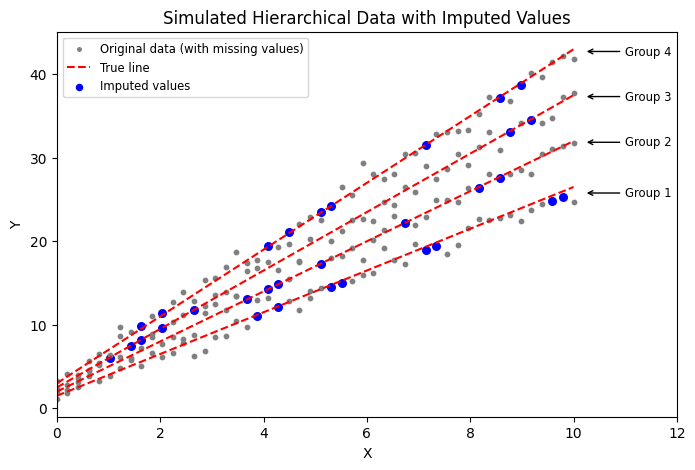

In [20]:
# Visualize imputed values
plt.figure(figsize=(8, 5))

for i in range(n_groups):
    plt.scatter(X, Y_missing[i*n:(i+1)*n], s=10, color='gray')  # Original data
    plt.plot(X, true_intercepts[i] + true_slopes[i] * X, color='red', linestyle='--')  # True line

    group_mask = missing_mask[i*n:(i+1)*n]  # Mask for missing values
    imputed_group_values = imputed_values[:, :, i*n:(i+1)*n].mean(axis=(0, 1))  # Imputed values

    plt.scatter(X[group_mask], imputed_group_values[group_mask], s=30, color='blue')  # Overlay imputed values

    plt.annotate(f'Group {i+1}', xy=(X[-1] + 0.2, imputed_group_values[-1]),
                 xytext=(X[-1] + 1, imputed_group_values[-1]),
                 fontsize='small', verticalalignment='center',
                 arrowprops=dict(facecolor='black', arrowstyle='->'))  # Group label with arrow

# Adjust legend and extend x-axis
plt.legend(['Original data (with missing values)', 'True line', 'Imputed values'], fontsize='small', loc='best', markerscale=0.8)
plt.xlim(0, X.max() + 2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Hierarchical Data with Imputed Values')
plt.show()

## Prior Sensitivity Analysis

In [21]:
# Define a model with weak prios
with pm.Model() as hierarchical_model_weak_prior:
    # Hyperpriors for the group nodes
    mu_intercept_wp = pm.Normal("mu_intercept_wp", mu=0, sigma=100)  # Weak prior
    sigma_intercept_wp = pm.HalfNormal("sigma_intercept_wp", sigma=10)

    mu_slope_wp = pm.Normal("mu_slope_wp", mu=0, sigma=100)  # Weak prior
    sigma_slope_wp = pm.HalfNormal("sigma_slope_wp", sigma=10)

    # Group-level intercepts and slopes
    intercepts_wp = pm.Normal("intercepts_wp", mu=mu_intercept_wp, sigma=sigma_intercept_wp, shape=n_groups)
    slopes_wp = pm.Normal("slopes_wp", mu=mu_slope_wp, sigma=sigma_slope_wp, shape=n_groups)

    # Model error
    sigma_wp = pm.HalfNormal("sigma_wp", sigma=10)

    # Expected value of the outcome
    mu_wp = intercepts_wp[group_idx] + slopes_wp[group_idx] * np.tile(X, n_groups)

    # Handling missing data automatically
    Y_obs_wp = pm.Normal("Y_obs_wp", mu=mu_wp, sigma=sigma_wp, observed=Y_missing)

    # Sample from the posterior
    trace_wp = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True})

In [22]:
# Perform posterior predictive checks
with hierarchical_model_weak_prior:
    posterior_predictive_wp = pm.sample_posterior_predictive(trace_wp, var_names=["Y_obs_wp"])

# Extract the posterior predictive samples (includes imputed values)
imputed_values_wp = posterior_predictive_wp.posterior_predictive["Y_obs_wp"].values

# Print details about the imputed values
print(f"\nImputed values shape (weak prior): {imputed_values_wp.shape}")


Imputed values shape (weak prior): (4, 2000, 200)


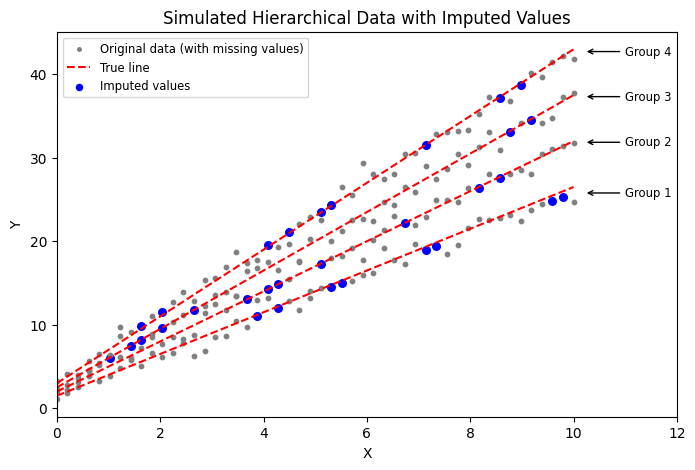

In [23]:
# Visualize imputed values
plt.figure(figsize=(8, 5))

for i in range(n_groups):
    plt.scatter(X, Y_missing[i*n:(i+1)*n], s=10, color='gray')  # Original data
    plt.plot(X, true_intercepts[i] + true_slopes[i] * X, color='red', linestyle='--')  # True line

    group_mask = missing_mask[i*n:(i+1)*n]  # Mask for missing values
    imputed_group_values = imputed_values_wp[:, :, i*n:(i+1)*n].mean(axis=(0, 1))  # Imputed values

    plt.scatter(X[group_mask], imputed_group_values[group_mask], s=30, color='blue')  # Overlay imputed values

    plt.annotate(f'Group {i+1}', xy=(X[-1] + 0.2, imputed_group_values[-1]),
                 xytext=(X[-1] + 1, imputed_group_values[-1]),
                 fontsize='small', verticalalignment='center',
                 arrowprops=dict(facecolor='black', arrowstyle='->'))  # Group label with arrow

# Adjust legend and extend x-axis
plt.legend(['Original data (with missing values)', 'True line', 'Imputed values'], fontsize='small', loc='best', markerscale=0.8)
plt.xlim(0, X.max() + 2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Hierarchical Data with Imputed Values')
plt.show()

In [24]:
# Non-Centered Parameterization
with pm.Model() as hierarchical_model_nc:
    # Hyperpriors for the group nodes
    mu_intercept_nc = pm.Normal("mu_intercept_nc", mu=0, sigma=10)
    sigma_intercept_nc = pm.HalfNormal("sigma_intercept_nc", sigma=1)

    mu_slope_nc = pm.Normal("mu_slope_nc", mu=0, sigma=10)
    sigma_slope_nc = pm.HalfNormal("sigma_slope_nc", sigma=1)

    # Non-centered parameterization for group-level intercepts and slopes
    intercepts_offset = pm.Normal("intercepts_offset", mu=0, sigma=1, shape=n_groups)
    intercepts_nc = pm.Deterministic("intercepts_nc", mu_intercept_nc + sigma_intercept_nc * intercepts_offset)

    slopes_offset = pm.Normal("slopes_offset", mu=0, sigma=1, shape=n_groups)
    slopes_nc = pm.Deterministic("slopes_nc", mu_slope_nc + sigma_slope_nc * slopes_offset)

    # Model error
    sigma_nc = pm.HalfNormal("sigma_nc", sigma=1)

    # Expected value of the outcome
    mu_nc = intercepts_nc[group_idx] + slopes_nc[group_idx] * np.tile(X, n_groups)

    # Handling missing data automatically
    Y_obs_nc = pm.Normal("Y_obs_nc", mu=mu_nc, sigma=sigma_nc, observed=Y_missing)

    # Sample from the posterior
    trace_nc = pm.sample(2000, return_inferencedata=True, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True})

In [25]:
# Perform posterior predictive checks
with hierarchical_model_nc:
    posterior_predictive_nc = pm.sample_posterior_predictive(trace_nc, var_names=["Y_obs_nc"])

# Extract the posterior predictive samples (includes imputed values)
imputed_values_nc = posterior_predictive_nc.posterior_predictive["Y_obs_nc"].values

# Print details about the imputed values
print(f"\nImputed values shape (non-centered): {imputed_values_nc.shape}")


Imputed values shape (non-centered): (4, 2000, 200)


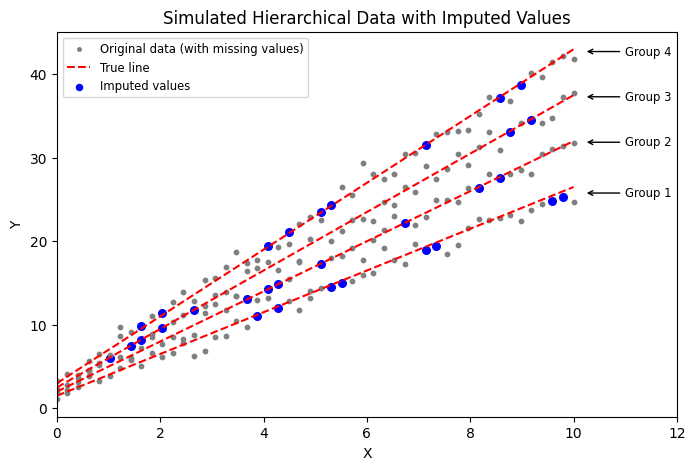

In [26]:
# Visualize imputed values
plt.figure(figsize=(8, 5))

for i in range(n_groups):
    plt.scatter(X, Y_missing[i*n:(i+1)*n], s=10, color='gray')  # Original data
    plt.plot(X, true_intercepts[i] + true_slopes[i] * X, color='red', linestyle='--')  # True line

    group_mask = missing_mask[i*n:(i+1)*n]  # Mask for missing values
    imputed_group_values = imputed_values_nc[:, :, i*n:(i+1)*n].mean(axis=(0, 1))  # Imputed values

    plt.scatter(X[group_mask], imputed_group_values[group_mask], s=30, color='blue')  # Overlay imputed values

    plt.annotate(f'Group {i+1}', xy=(X[-1] + 0.2, imputed_group_values[-1]),
                 xytext=(X[-1] + 1, imputed_group_values[-1]),
                 fontsize='small', verticalalignment='center',
                 arrowprops=dict(facecolor='black', arrowstyle='->'))  # Group label with arrow

# Adjust legend and extend x-axis
plt.legend(['Original data (with missing values)', 'True line', 'Imputed values'], fontsize='small', loc='best', markerscale=0.8)
plt.xlim(0, X.max() + 2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Hierarchical Data with Imputed Values')
plt.show()

## Variational Inference

In [27]:
# Inference using MCMC and Variational Inference (VI)
with hierarchical_model:
    trace_mcmc = pm.sample(2000, return_inferencedata=True, tune=2000, target_accept=0.99, idata_kwargs={"log_likelihood": True})

with hierarchical_model:
    approx = pm.fit(n=30000, method='fullrank_advi')  # Variational inference
    trace_vi = approx.sample(1000)

## Posterior Analysis

MCMC Trace Summary:


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Y_obs[0]     2.00  0.00    2.00     2.00       0.00      0.0   8000.00   
Y_obs[1]     1.87  0.00    1.87     1.87       0.00      0.0   8000.00   
Y_obs[2]     3.17  0.00    3.17     3.17       0.00      0.0   8000.00   
Y_obs[3]     4.55  0.00    4.55     4.55       0.00      0.0   8000.00   
Y_obs[4]     3.31  0.00    3.31     3.31       0.00      0.0   8000.00   
...           ...   ...     ...      ...        ...      ...       ...   
sigma_slope  0.84  0.35    0.34     1.49       0.01      0.0   5902.58   
slopes[0]    2.40  0.05    2.32     2.49       0.00      0.0   5569.99   
slopes[1]    2.97  0.05    2.89     3.06       0.00      0.0   4950.69   
slopes[2]    3.48  0.05    3.40     3.58       0.00      0.0   5419.25   
slopes[3]    3.93  0.05    3.84     4.02       0.00      0.0   5385.41   

             ess_tail  r_hat  
Y_obs[0]      8000.00    NaN  
Y_obs[1]      8000.00    NaN  
Y_obs[2]      8000.00    NaN  
Y_obs[3]      8000.00    NaN  
Y_obs[4]      8000.00    NaN  
...               ...    ...  
sigma_slope   4656.02    1.0  
slopes[0]     5514.83    1.0  
slopes[1]     4814.49    1.0  
slopes[2]     5177.11    1.0  
slopes[3]     5662.96    1.0  

[244 rows x 9 columns]

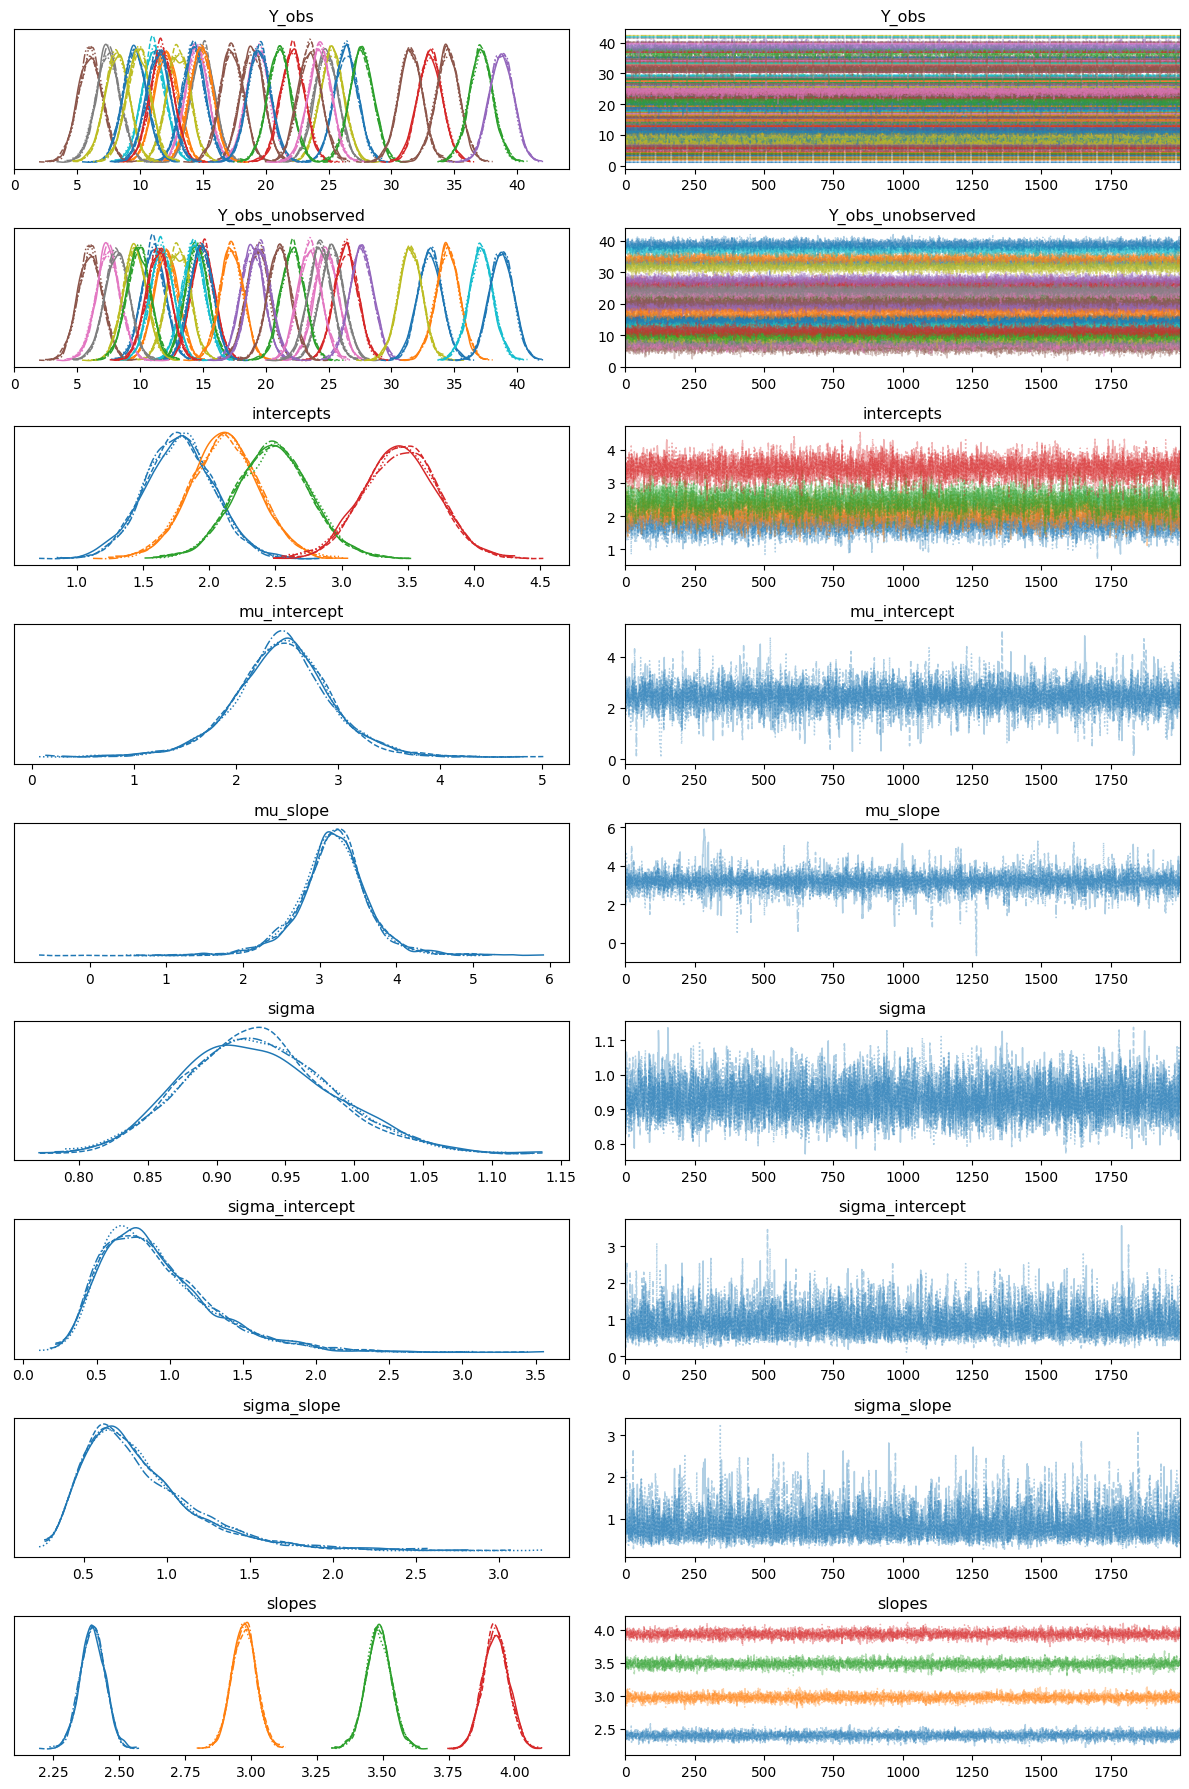

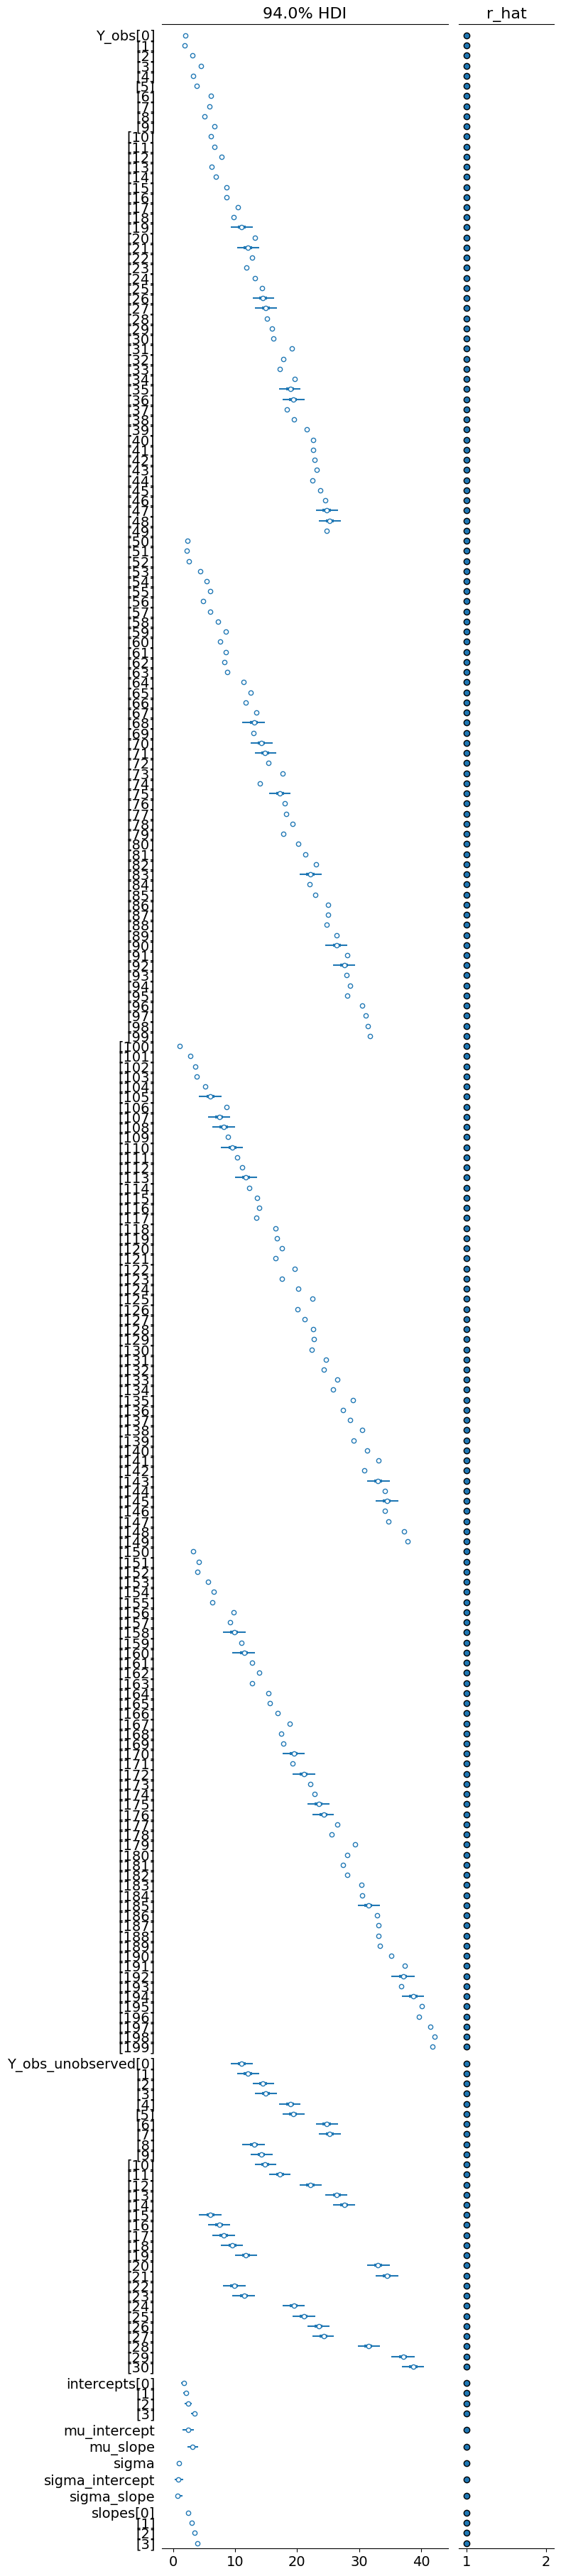

In [28]:
# Summary of the MCMC trace
print("MCMC Trace Summary:")
display(az.summary(trace_mcmc, round_to=2))

# Plotting the MCMC trace
print("\n")
az.plot_trace(trace_mcmc)
plt.tight_layout()
plt.show()

print("\n")
az.plot_forest(trace_mcmc, r_hat=True, combined=True)
plt.tight_layout()
plt.show()

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


VI Trace Summary:


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Y_obs[0]     2.00  0.00    2.00     2.00       0.00     0.00   1000.00   
Y_obs[1]     1.87  0.00    1.87     1.87       0.00     0.00   1000.00   
Y_obs[2]     3.17  0.00    3.17     3.17       0.00     0.00   1000.00   
Y_obs[3]     4.55  0.00    4.55     4.55       0.00     0.00   1000.00   
Y_obs[4]     3.31  0.00    3.31     3.31       0.00     0.00   1000.00   
...           ...   ...     ...      ...        ...      ...       ...   
sigma_slope  0.88  0.37    0.31     1.56       0.01     0.01    832.39   
slopes[0]    1.97  0.24    1.56     2.42       0.01     0.01   1002.58   
slopes[1]    2.62  0.24    2.16     3.08       0.01     0.01    979.15   
slopes[2]    3.13  0.24    2.73     3.61       0.01     0.01    984.14   
slopes[3]    3.38  0.25    2.88     3.82       0.01     0.01    991.97   

             ess_tail  r_hat  
Y_obs[0]      1000.00    NaN  
Y_obs[1]      1000.00    NaN  
Y_obs[2]      1000.00    NaN  
Y_obs[3]      1000.00    NaN  
Y_obs[4]      1000.00    NaN  
...               ...    ...  
sigma_slope    897.24    NaN  
slopes[0]      977.68    NaN  
slopes[1]      961.70    NaN  
slopes[2]      877.25    NaN  
slopes[3]      718.34    NaN  

[244 rows x 9 columns]

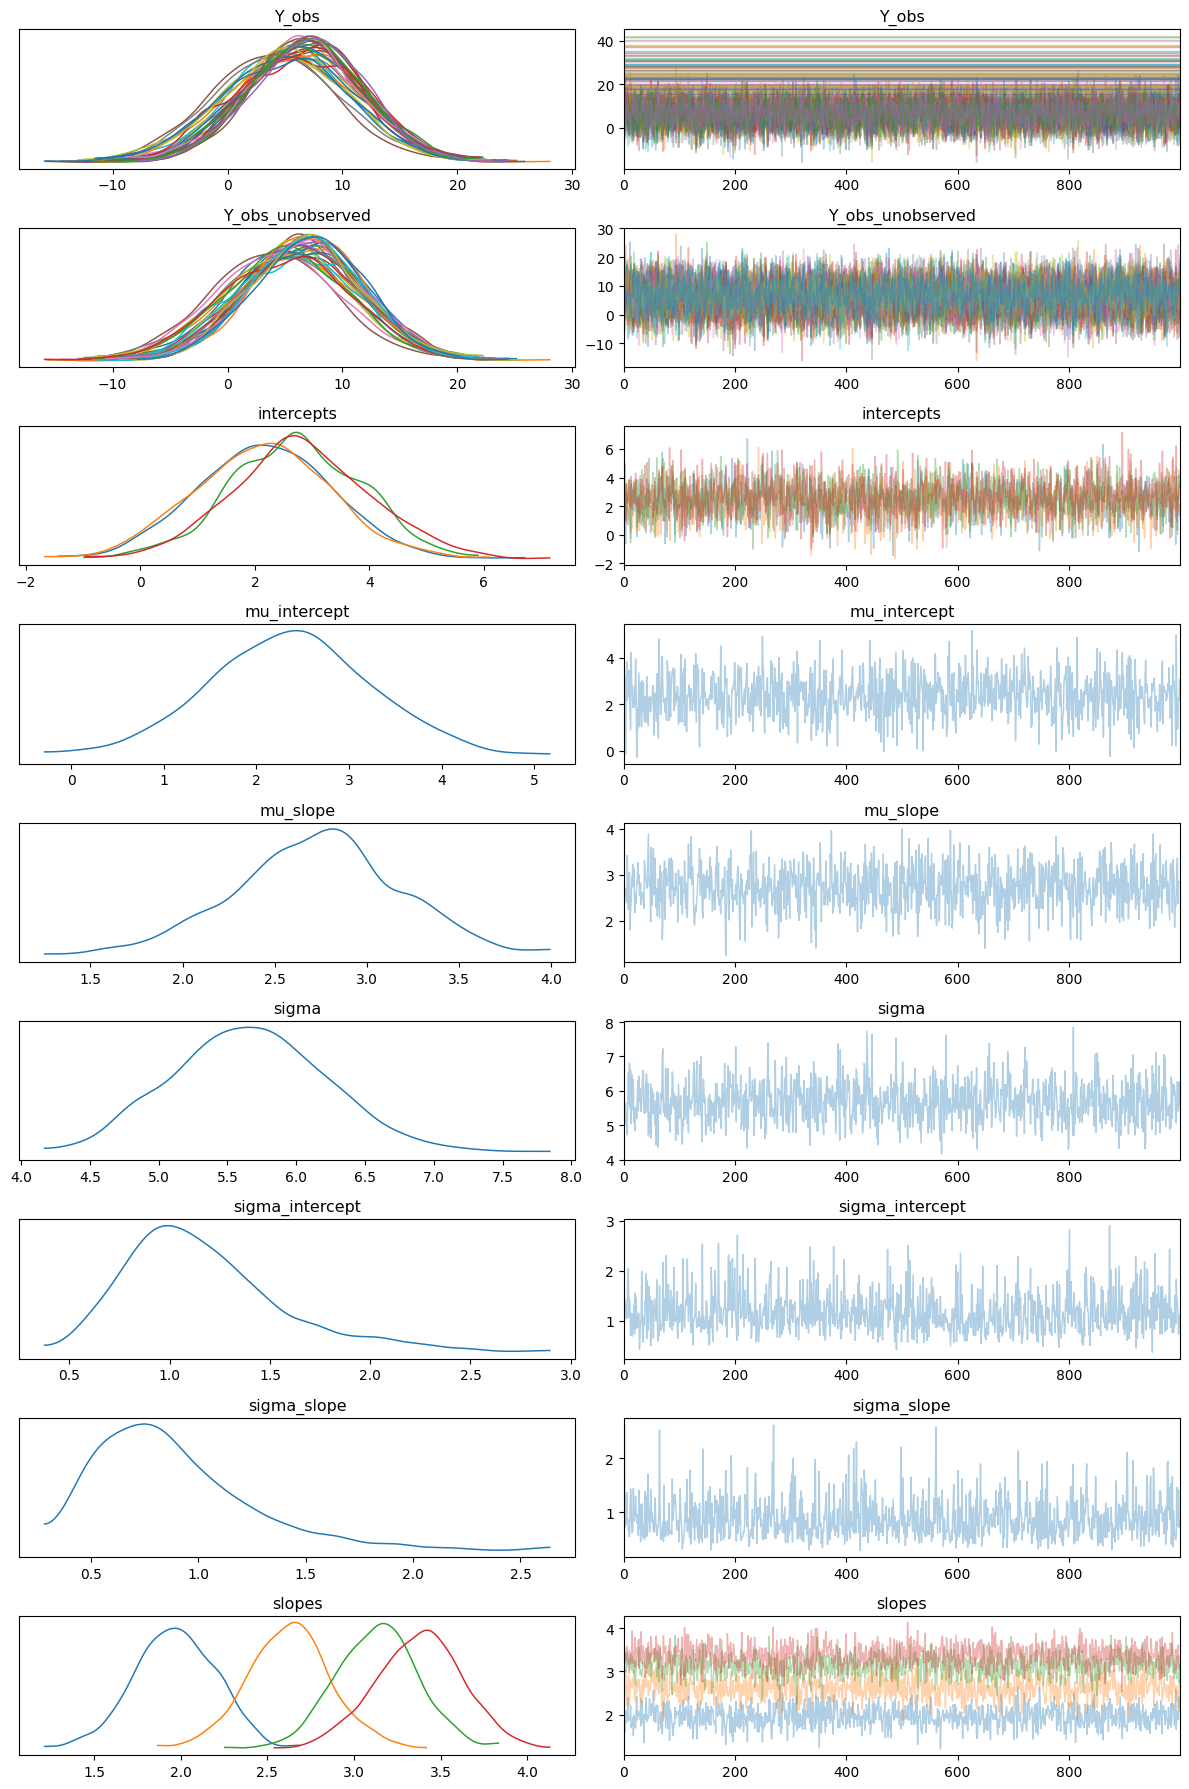

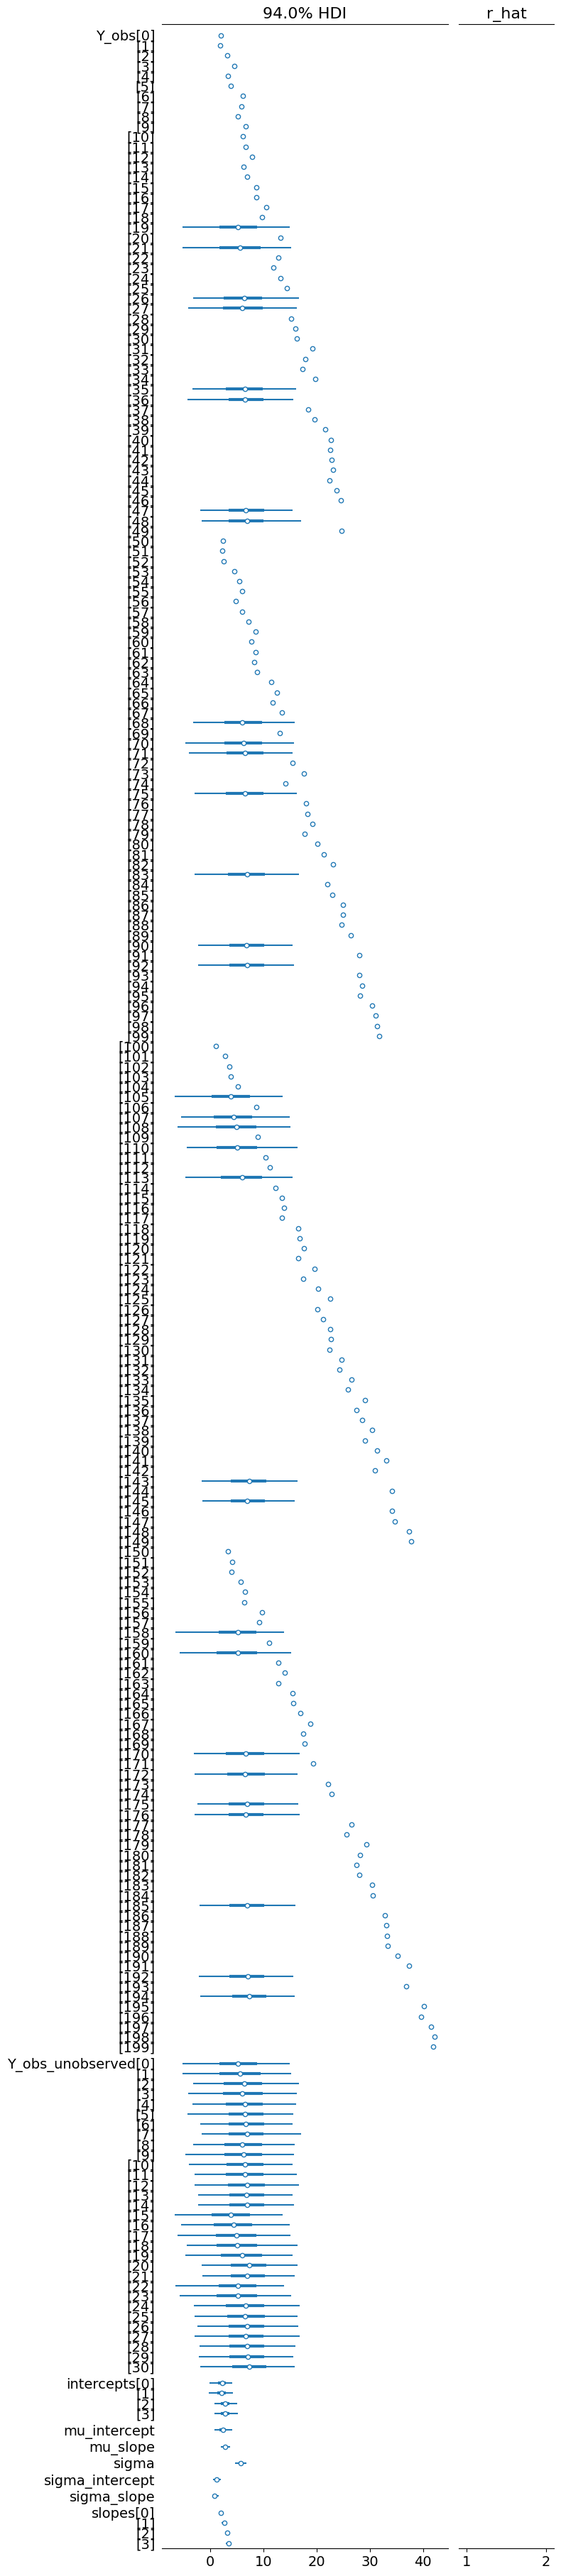

In [29]:
# Summary of the VI trace
print("VI Trace Summary:")
display(az.summary(trace_vi, round_to=2))

# Plotting the VI trace
print("\n")
az.plot_trace(trace_vi)
plt.tight_layout()
plt.show()

print("\n")
az.plot_forest(trace_vi, r_hat=True, combined=True)
plt.tight_layout()
plt.show()

## Model Diagnostics

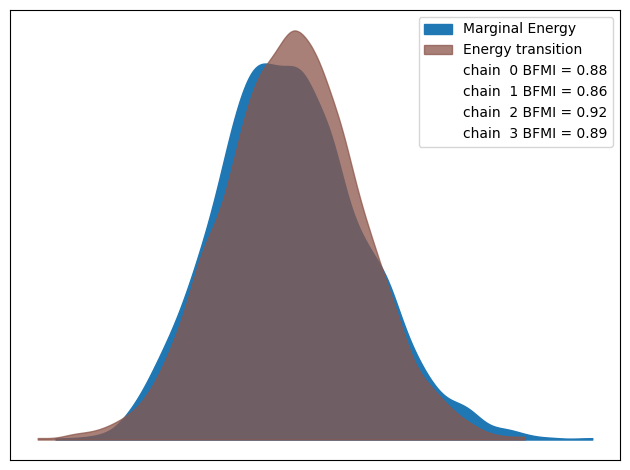


R-hat values for MCMC (should be close to 1):
 <xarray.Dataset> Size: 4kB
Dimensions:                 (Y_obs_dim_0: 200, Y_obs_unobserved_dim_0: 31,
                             intercepts_dim_0: 4, slopes_dim_0: 4)
Coordinates:
  * Y_obs_dim_0             (Y_obs_dim_0) int64 2kB 0 1 2 3 ... 196 197 198 199
  * Y_obs_unobserved_dim_0  (Y_obs_unobserved_dim_0) int64 248B 0 1 2 ... 29 30
  * intercepts_dim_0        (intercepts_dim_0) int64 32B 0 1 2 3
  * slopes_dim_0            (slopes_dim_0) int64 32B 0 1 2 3
Data variables:
    Y_obs                   (Y_obs_dim_0) float64 2kB nan nan nan ... nan nan
    Y_obs_unobserved        (Y_obs_unobserved_dim_0) float64 248B 1.001 ... 0...
    intercepts              (intercepts_dim_0) float64 32B 1.0 1.001 1.0 1.0
    mu_intercept            float64 8B 1.0
    mu_slope                float64 8B 1.001
    sigma                   float64 8B 1.001
    sigma_intercept         float64 8B 1.0
    sigma_slope             float64 8B 1.0
    slopes   

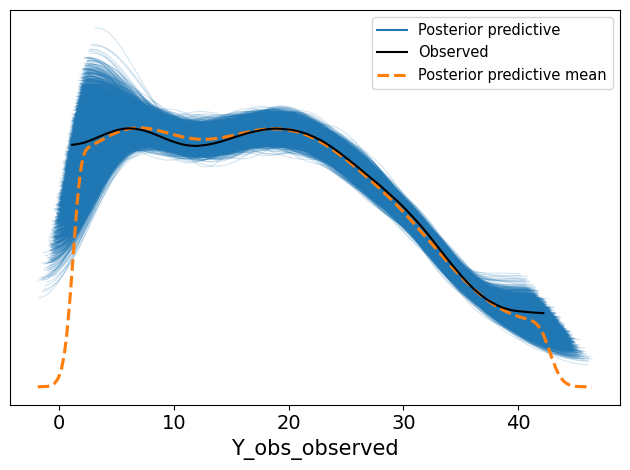

In [30]:
# Energy plot for MCMC
az.plot_energy(trace_mcmc)
plt.tight_layout()
plt.show()

# Convergence diagnostics for MCMC
rhat_values = az.rhat(trace_mcmc)
print("\nR-hat values for MCMC (should be close to 1):\n", rhat_values)

# Posterior predictive checks for MCMC
with hierarchical_model:
    posterior_predictive_mcmc = pm.sample_posterior_predictive(trace_mcmc, return_inferencedata=True)

# Plot posterior predictive checks
print("\n")
az.plot_ppc(posterior_predictive_mcmc)
plt.tight_layout()
plt.show()

## Model Comparison

In [31]:
# Compute WAIC and LOO for each model
with hierarchical_model:
    waic_mcmc = az.waic(trace_mcmc)
    loo_mcmc = az.loo(trace_mcmc)

with hierarchical_model_weak_prior:
    waic_wp = az.waic(trace_wp)
    loo_wp = az.loo(trace_wp)

with hierarchical_model_nc:
    waic_nc = az.waic(trace_nc)
    loo_nc = az.loo(trace_nc)

# Perform model comparison using WAIC
model_comparison_waic = az.compare({"MCMC": trace_mcmc, "Weak Prior": trace_wp, "Non-Centered": trace_nc}, ic="waic")
print("Model Comparison using WAIC:")
display(model_comparison_waic)

# Perform model comparison using LOO
model_comparison_loo = az.compare({"MCMC": trace_mcmc, "Weak Prior": trace_wp, "Non-Centered": trace_nc}, ic="loo")
print("\nModel Comparison using LOO:")
display(model_comparison_loo)

Model Comparison using WAIC:


rank   elpd_waic    p_waic  elpd_diff  weight        se  \
MCMC             0 -231.306579  7.669164   0.000000     1.0  9.191863   
Non-Centered     1 -231.404514  7.735549   0.097935     0.0  9.165429   
Weak Prior       2 -231.412394  7.798438   0.105816     0.0  9.117475   

                   dse  warning scale  
MCMC          0.000000    False   log  
Non-Centered  0.049436    False   log  
Weak Prior    0.186968    False   log


Model Comparison using LOO:


rank    elpd_loo     p_loo  elpd_diff        weight        se  \
MCMC             0 -231.337444  7.700029   0.000000  1.000000e+00  9.194595   
Non-Centered     1 -231.435557  7.766593   0.098114  5.551115e-17  9.168139   
Weak Prior       2 -231.449759  7.835802   0.112315  0.000000e+00  9.121407   

                   dse  warning scale  
MCMC          0.000000    False   log  
Non-Centered  0.050214    False   log  
Weak Prior    0.186830    False   log

## Save & Load Model

File hierarchical_model_trace_mcmc.nc already exists. Skipping save step.



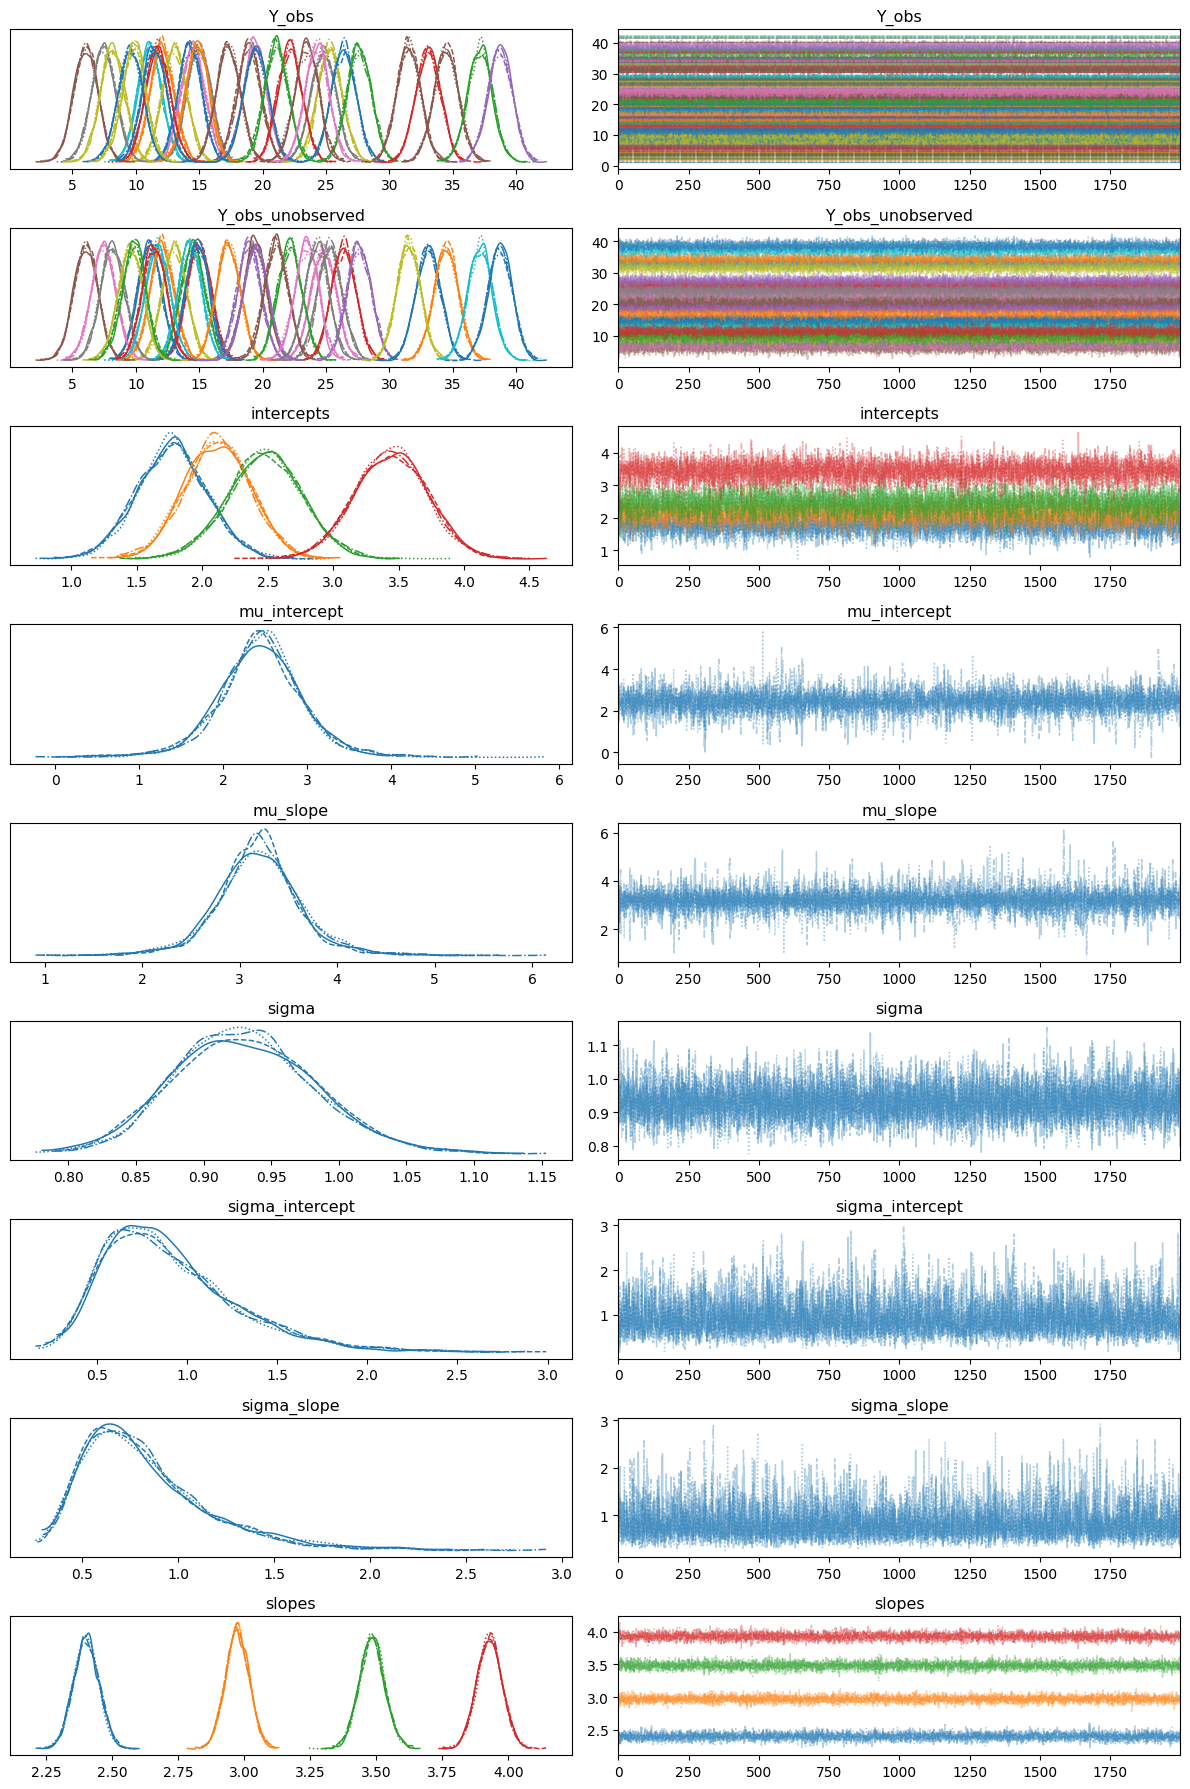

In [32]:
# Define the file path
file_path = "hierarchical_model_trace_mcmc.nc"

# Check if the file already exists
if not os.path.exists(file_path):
    # Save the model and trace
    az.to_netcdf(trace_mcmc, file_path)
    print(f"Trace saved to {file_path}")
else:
    print(f"File {file_path} already exists. Skipping save step.\n")

# Load the trace
loaded_trace = az.from_netcdf(file_path)

# Verify that the trace is loaded correctly
az.plot_trace(loaded_trace)
plt.tight_layout()
plt.show()